In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import  FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/')

from Dataset_Creation import sys_dataset
import Dataset_load

## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov()

## Varying the Exposure

In [4]:
savefig = True
picformat = 'svg'



In [5]:
bias = 0.1
sigma = 0

def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        sigma = s,
                        rnd = False,
                        e_reco_creation=10)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(1)
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    dataset_conv_N.e_reco_n = 10
    
    # new fine binned IRF Model
    dataset_conv_N_fine =  sys_d_cor.create_dataset_N(10)

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2, 2))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/b**2, 1/zero**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_conv_N_fine.penalising_invcovmatrix = penalising_invcovmatrix
    
    return dataset_conv, dataset_conv_N, dataset_conv_N_fine

dataset, dataset_N , _ = create_dataset(bias, sigma)

In [6]:
%%time
fitting = False
if fitting:
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(dataset)
else:
    path = f'data/2_model_{bias}_sigma_{sigma}.yml'
    dataset = Dataset_load.load_dataset_N(dataset, path)        

CPU times: user 92.4 ms, sys: 195 ms, total: 288 ms
Wall time: 45.1 ms


In [7]:
%%time
if fitting:
    fit_N = Fit(store_trace=False)
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(dataset_N)
else:
    path = f'data/2_model_nui_{bias}_sigma_{sigma}.yml'
    dataset_N = Dataset_load.load_dataset_N(dataset_N, path)

CPU times: user 27.4 ms, sys: 0 ns, total: 27.4 ms
Wall time: 26.8 ms


In [101]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV


color_standard = 'maroon'; color_standard_e = 'lightsalmon'
color_nui = 'navy'; color_nui_e = 'steelblue'

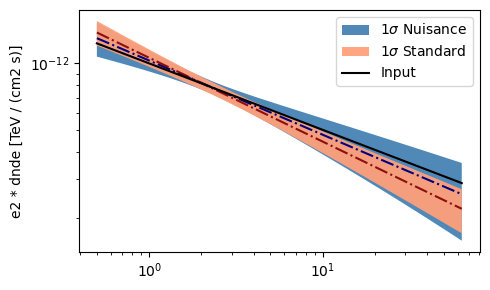

In [102]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (5,3))

  

dataset_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = color_nui_e, alpha = 0.95)  
dataset_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,linestyle='dashdot',
                                label = "", color = color_nui)  
    
dataset.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,linestyle='dashdot',
                                label = "", color = color_standard, alpha = 0.9)    

dataset.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = color_standard_e,
                                                   alpha = 0.95)

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle='-', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()


## Compute Asimov Fluxpoints


In [10]:
compute_fluxpoints = 0
if compute_fluxpoints:
    energy_edges = dataset_asimov.geoms['geom'].axes[0].edges
    esti  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = False)
    fluxpoints_asimov = esti.run([dataset_asimov])
    fluxpoints_asimov.write("data/6_fluxpoints_asimov.fits", overwrite = True)
else:
    fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits", )


In [11]:
%%time
if compute_fluxpoints:

    esti_N  = FluxPointsEstimator(energy_edges= energy_edges,
                               reoptimize = True)
    with dataset_asimov_N.models.restore_status():
        dataset_asimov_N.models.parameters.freeze_all()
        dataset_asimov_N.models.parameters['bias'].frozen = False
        fluxpoints_asimov_N = esti_N.run(dataset_asimov_N)

    fluxpoints_asimov_N.write("data/6_fluxpoints_asimov_N.fits", overwrite = True)
else:
    fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits",)
    

CPU times: user 16.7 ms, sys: 797 µs, total: 17.5 ms
Wall time: 16.9 ms


In [12]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

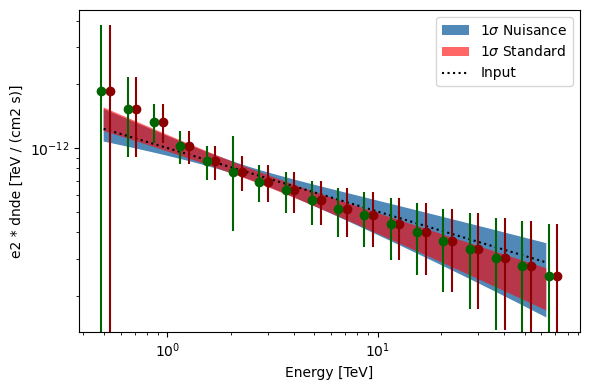

In [94]:
fig, axs = plt.subplots(1,1, figsize = (6,4))
dataset_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = color_nui_e, alpha = 0.95)    
    
dataset.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )


e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/6_fluxpoints_asimov."+ picformat)
